In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from helper_functions import *
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
save = True
load = False

In [4]:
dmr_esmr_ir_mapping = pd.read_csv('processed_data/step1/dmr_esmr_ir_mapping.csv')
parent_category_map = dict(zip(dmr_esmr_ir_mapping['PARAMETER_CODE'], dmr_esmr_ir_mapping['PARENT_CATEGORY']))
sub_category_map = dict(zip(dmr_esmr_ir_mapping['PARAMETER_CODE'], dmr_esmr_ir_mapping['SUB_CATEGORY']))
categories = ['Temperature', 'Metals', 'Uncategorized', 'Radiation',
       'Dissolved Solids', 'Nitrogen', 'Disinfectants', 'Toxic Organics',
       'Dissolved Oxygen', 'COD', 'Other', 'Fuel', 'pH', 'Flow',
       'Pathogens', 'Toxic Inorganics', 'Other Organics',
       'Suspended Solids', 'Turbidity', 'Color']
# for this analysis, we only want to considere categories of parameter that are 
# not automatically regulated by NPDES secondary standars
categories = ['Temperature', 'Metals',
       'Dissolved Solids', 'Nitrogen', 'Phosphorus', 'Disinfectants',
       'Dissolved Oxygen',
       'Pathogens', 'Toxic Inorganics',
       'Turbidity', 'Color']

In [5]:
facilities_list = pd.read_csv('data/facilities_list/NPDES+WDR Facilities List_20240906.csv')

limits_2023 = read_limits(2023)
limits_2023['PARENT_CATEGORY'] = limits_2023['PARAMETER_CODE'].map(parent_category_map)
limits_2023['SUB_CATEGORY'] = limits_2023['PARAMETER_CODE'].map(sub_category_map)
limits_2023.head()

# Import and process 303d lists for 2018 and 2024
columns_to_keep = ['Water Body CALWNUMS', 'Pollutant', 'Pollutant Category', 'Decision Status', 'TMDL Requirement Status',
                   'Sources', 'Expected TMDL Completion Date', 'Expected Attainment Date']
impaired_303d_2018 = pd.read_csv('data/ir/2018-303d.csv', skiprows=2)[columns_to_keep].dropna(subset=['Water Body CALWNUMS'])
impaired_303d_2024 = pd.read_csv('data/ir/2024-303d.csv', skiprows=1)[columns_to_keep].dropna(subset=['Water Body CALWNUMS'])

# Create a dictionary to store the newly impaired water bodies for each category
newly_impaired_water_bodies = defaultdict(set)
impaired_water_bodies = defaultdict(set)
for category in categories:
    impaired_set_2018 = set(impaired_303d_2018.loc[impaired_303d_2018['Pollutant Category'] == category, 'Water Body CALWNUMS'])
    impaired_set_2024 = set(impaired_303d_2024.loc[impaired_303d_2024['Pollutant Category'] == category, 'Water Body CALWNUMS'])
    newly_impaired_water_bodies[category] = impaired_set_2024 - impaired_set_2018
    impaired_water_bodies[category] = impaired_set_2024

def contains_impaired_water_body(watershed_name, impaired_water_bodies):
    if pd.isna(watershed_name):
        return False
    return any(water_body in watershed_name for water_body in impaired_water_bodies)

print(' checking for facilities discharging to newly impaired water bodies')
for category in categories:
    print(category)
    facilities_list[f'Discharges to Newly {category} Impaired'] = facilities_list['CAL WATERSHED NAME'].apply(contains_impaired_water_body, impaired_water_bodies=newly_impaired_water_bodies[category])
    facilities_list[f'Discharges to {category} Impaired'] = facilities_list['CAL WATERSHED NAME'].apply(contains_impaired_water_body, impaired_water_bodies=impaired_water_bodies[category])
    facilities_list[f'Discharges to Newly {category} Impaired and Not Limited'] = False
    for index, row in facilities_list.iterrows():
        sub_limits_2023 = limits_2023[limits_2023['EXTERNAL_PERMIT_NMBR'] == row['NPDES # CA#']]
        if row[f'Discharges to Newly {category} Impaired']:
            for _, limit_row in sub_limits_2023.iterrows():
                # print(limit_row['LIMIT_VALUE_NMBR'], category)
                if limit_row['SUB_CATEGORY'] == category and (limit_row['LIMIT_VALUE_NMBR']=='nan' or limit_row['LIMIT_VALUE_NMBR']=='' or limit_row['LIMIT_VALUE_NMBR'].isna()):
                    facilities_list.at[index, f'Discharges to Newly {category} Impaired and Not Limited'] = True
                    break
                facilities_list.at[index, f'Discharges to Newly {category} Impaired and Not Limited'] = True

2023 limits data has 155523 limits and 437 unique permits
 checking for facilities discharging to newly impaired water bodies
Temperature
Metals
Dissolved Solids
Nitrogen
Phosphorus
Disinfectants
Dissolved Oxygen
Pathogens
Toxic Inorganics
Turbidity
Color


In [ ]:
# consolidate to a single column. Add the category name(s) to the column
facilities_list['Discharges to Impaired Water Bodies and Not Limited'] = facilities_list.apply(
    lambda row: ' and '.join(
        [category for category in categories if row[f'Discharges to Newly {category} Impaired and Not Limited']
         ]
         ), axis=1)

In [ ]:
save = True
load = False
if save:
    facilities_list.to_csv('processed_data/facilities_with_future_limits.csv', index=False)
if load:
    facilities_list = pd.read_csv('processed_data/facilities_with_future_limits.csv')

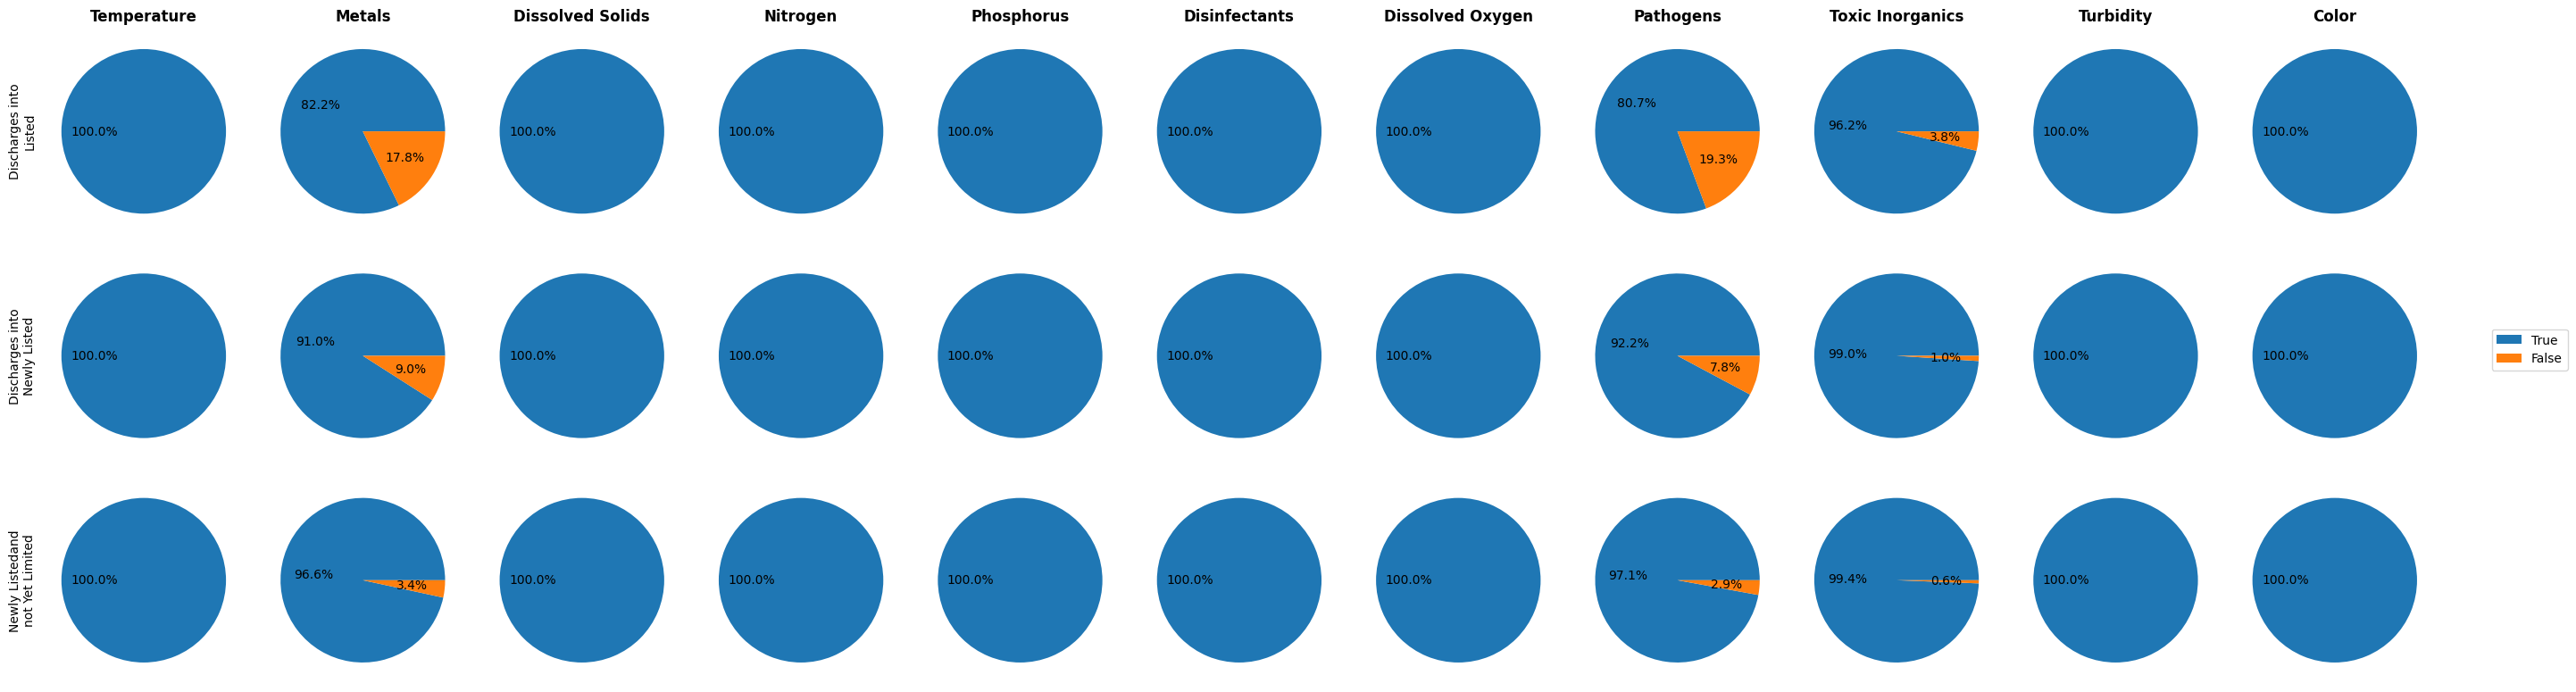

In [ ]:
num_categories = len(categories)
fig, axes = plt.subplots(3, num_categories, figsize=(2.5*num_categories, 8))

# Ensure axes is always a 2D array, even for a single category
if num_categories == 1:
    axes = axes.reshape(3, 1)

# Set column titles (categories) as the top subplot title
for i, category in enumerate(categories):
    axes[0, i].set_title(category, fontsize=12, fontweight='bold')

row_titles = ['Discharges into\nListed', 'Discharges into\nNewly Listed', 'Newly Listedand\nnot Yet Limited']

for i, category in enumerate(categories):
    # Plot facilities discharging to any impaired water bodies
    data = facilities_list[f'Discharges to {category} Impaired'].value_counts()
    data.plot(kind='pie', autopct='%1.1f%%', ax=axes[0, i], label=row_titles[0] if i == 0 else '', labels=None)
    
    # Plot facilities discharging to newly impaired water bodies
    data2 = facilities_list[f'Discharges to Newly {category} Impaired'].value_counts()
    data2.plot(kind='pie', autopct='%1.1f%%', ax=axes[1, i], label=row_titles[1] if i == 0 else '', labels=None)
    
    # Plot facilities discharging to newly impaired water bodies and not limited
    data3 = facilities_list[f'Discharges to Newly {category} Impaired and Not Limited'].value_counts()
    data3.plot(kind='pie', autopct='%1.1f%%', ax=axes[2, i], label=row_titles[2] if i == 0 else '', labels=None)

# Add a single legend to the right of the columns
handles = [plt.Rectangle((0,0),1,1,fc="C0"), plt.Rectangle((0,0),1,1,fc="C1")]
labels = ['True', 'False']
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.05, 0.5))

plt.tight_layout()
plt.show()

/var/folders/qq/0h1nl0vj595_tgrwtkm73yjm0000gn/T/ipykernel_67181/10684909.py:23: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf[gdf[f'Discharges to Newly {sub_category} Impaired and Not Limited'] == True].plot(ax=ax, color='red', markersize=4, alpha=0.5, label=f'Discharge to Newly {sub_category} Impaired Water Bodies since 2018')


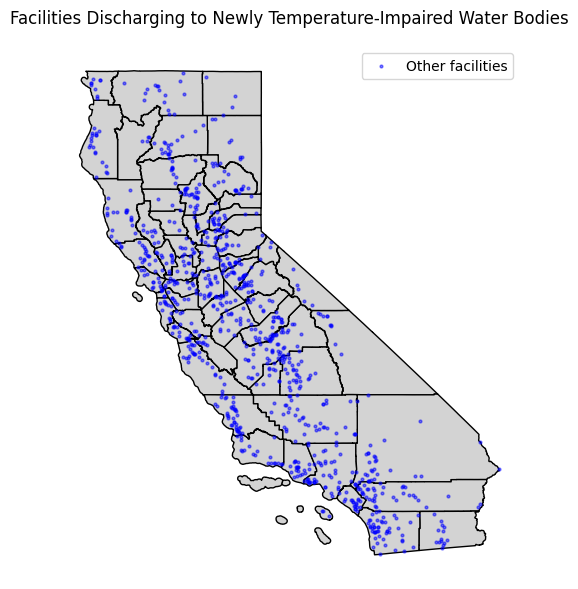

In [ ]:
def plot_facilities_discharge(sub_category):
    # Create a GeoDataFrame from facilities_list
    gdf = gpd.GeoDataFrame(
        facilities_list, 
        geometry=[Point(xy) for xy in zip(facilities_list['LONGITUDE DECIMAL DEGREES'],
                                          facilities_list['LATITUDE DECIMAL DEGREES'])],
        crs="EPSG:4326"
    )

    california = gpd.read_file('data/ca_counties/CA_Counties.shp')

    # If CRS don't match, reproject one to match the other
    if gdf.crs != california.crs:
        if california.crs is None:
            california = california.set_crs(gdf.crs)
        else:
            gdf = gdf.to_crs(california.crs)

    # plot county outlines and facilites
    fig, ax = plt.subplots(figsize=(6, 6))
    california.plot(ax=ax, color='lightgrey', edgecolor='black')
    gdf[gdf[f'Discharges to Newly {sub_category} Impaired and Not Limited'] == False].plot(ax=ax, color='blue', markersize=4, alpha=0.5, label='Other facilities')
    gdf[gdf[f'Discharges to Newly {sub_category} Impaired and Not Limited'] == True].plot(ax=ax, color='red', markersize=4, alpha=0.5, label=f'Discharge to Newly {sub_category} Impaired Water Bodies since 2018')

    ax.set_title(f'Facilities Discharging to Newly {sub_category}-Impaired Water Bodies')
    ax.legend()
    ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_facilities_discharge('Temperature')